# Task 1:
First we create variables for time range and function to check whether an order is made in said ranges.

In [1]:
import datetime
import time
import csv
current_date = datetime.datetime.strptime("2021-01-14 00:00:00", "%Y-%m-%d %H:%M:%S")       #current date taken as 2021-01-14 for convenience 
past_date_limit = datetime.datetime.strptime("2020-10-14 00:00:00", "%Y-%m-%d %H:%M:%S")    #last 3 months relative to current date
future_date_limit = datetime.datetime.strptime("2021-04-14 00:00:00", "%Y-%m-%d %H:%M:%S")  #future 3 months relative to current date

def in_last_3_months(str_date):                                                             #function to check if order made in last 3 months
    date = datetime.datetime.strptime(str_date,"%Y-%m-%d %H:%M:%S")
    return date >= past_date_limit and date <= current_date

def in_next_3_months(str_date):                                                             #function to check if order made in next 3 months
    date = datetime.datetime.strptime(str_date,"%Y-%m-%d %H:%M:%S")
    return date > current_date and date <= future_date_limit


Main code for creating the dataset containing information about order_number, count_last_3_months, gross_value_last_3_months, count_next_3_months, gross_value_next_3_months. Customer_info is a 'table' where the customer is the primary key and the other values are Count of orders in the past and fututre 3 months, and their gross values respectiely. Orders_info with order_number being the primary key and other values are order_date and order_value.

In [2]:

customers_and_orders = set()
customers = set()
with open('test_sales.csv',newline='', encoding='utf-8') as csvfile:
    i=0
    test_sales = csv.DictReader(csvfile)
    for entry in test_sales:                                                             #Cycle through data set to get info about customers
        customers_and_orders.add((entry["customer_id"],entry["order_number"]))           # and orders

    
    customer_info = {customer:[0,0.,0,0.] for (customer,_) in customers_and_orders}     #customer_info is a 'table' where the customer is the primary
    orders_info = {order_number:['',''] for (_,order_number) in customers_and_orders}

    csvfile.seek(0)
    next(csvfile)

    i=0
    #Update info about customers (customer_id,orders_in_last_3_months,gross_value_orders_last_3_months,
    # orders_next_3_months,gross_value_orders_next_3_months)
    #and info about orders (order_datetime,order_gross_value)
    for entry in test_sales:
        order_datetime = entry["order_datetime"]
        order_value = entry["gross_value"]
        order_number = entry["order_number"]
        customer_id = entry["customer_id"]
        orders_info[order_number]=[order_datetime,order_value]
        if in_last_3_months(order_datetime) :
            customer_info[customer_id][0]+=1
            customer_info[customer_id][1]+=float(order_value)
        if in_next_3_months(order_datetime) :
            customer_info[customer_id][2]+=1
            customer_info[customer_id][3]+=float(order_value)

    #Create new csv file for the dataset by combining info from order_info and customer_info. Fields of the files are
    # specified in the header variable
    with open('test_result.csv','w', newline='',encoding='utf-8') as test_res_csv:    
        writer= csv.writer(test_res_csv)
        header = ["order_number","count_last_3_months","gross_value_last_3_months","count_next_3_months","gross_value_next_3_months"]
        writer.writerow(header)
        for (customer_id,order_number) in customers_and_orders:
            order_value= float(orders_info[order_number][1])                                 #first we subtract the order value
            order_last=in_last_3_months(orders_info[order_number][0])                        #from the customers info, if
            order_next=in_next_3_months(orders_info[order_number][0])                        #the order is in the last/next 3 months
            corrected_values = [customer_info[customer_id][0]-order_last,customer_info[customer_id][1]-order_last*order_value,customer_info[customer_id][2]-order_next,customer_info[customer_id][3]-order_next*order_value]
            writer.writerow([order_number]+corrected_values)                                 #Then we write the corrected info to the csv file

    

After the code executes we get a file 'test_result.csv' containing a dataset with the desired features. We can further import it in another python program or R env for further analysis.

For the second part of the tast I'll be using R, since it has easier access to some functions.

In [ ]:
%load_ext rpy2.ipython

In [4]:
%%R
#importing the test_result.csv
test_result <- read.csv("test_result.csv")

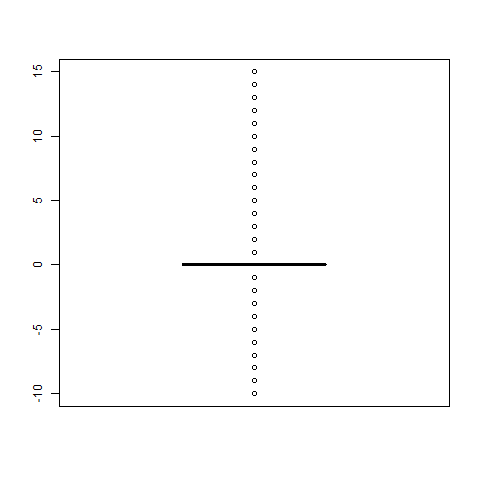

In [5]:
%%R
#Creating a new data.frame with the difference in total purchases and gross vlaue between last/future 3 months
ag_res <- data.frame(order_number=test_result$order_number,change_in_activity = test_result$count_last_3_months - test_result$count_next_3_months, gross_value_of_change = test_result$gross_value_last_3_months - test_result$gross_value_next_3_months)
summary(ag_res)
var(ag_res$change_in_activity)
var(ag_res$gross_value_of_change)
boxplot(ag_res$change_in_activity)

In [6]:
%%R
x<-ag_res$gross_value_of_change[ag_res$gross_value_of_change!=0 & ag_res$change_in_activity !=0]
y<-ag_res$change_in_activity[ag_res$gross_value_of_change!=0 & ag_res$change_in_activity !=0]
mean(x)              # mean(y)
sd(x)                # sd(y)
sum(x>0)/length(x)   # sum(y>0)/length(y)

[1] 0.6898734


From calling the summary function we can see that the activity hasn't changed a lot between the 2 time periods, but the median of the gross value of said purchases has increased. Furthermore, calling the sd() function on both column, we see that the change has a relatively low standart deviation - 1.485, meaning the observation are packed around the mean, but the s.d. of the second column is really big - 640.95, meaning that the data is more spread out around the mean. But if we removed the orders with 0 change in activity and 0 gross value change,  skewing our data, we get different results. For gross value we get mean = 312.96 and sd = 1303.15, meaning the data is even more spread out. We can also check what % of values are above 0 and we get roughly 69%, meaning we've observed a historic increase in activity.

# Task 2:
First we import the dataset, after which we modify it a little to remove unnecessary columns.

In [7]:
%%R
library(dplyr)
housing_price_data <- read.csv("./housing_price_data.csv")
modify <- function(df){
p_missing <-unlist(lapply(df,function(x) sum(is.na(x))))/nrow(df)
sort(p_missing[p_missing>0],decreasing = TRUE); #determine which  columns have many NAs


#Remove columns with 40+% of values as NA; Remove ID because of redundance;
#Remove Utilities, because it's insignificant - only 1 house doesnt have all utilities
df <- df %>%
  dplyr::select(-PoolQC,-MiscFeature,-Alley,-Fence,-FireplaceQu,-Id,-Utilities)  
df <- as.data.frame(unclass(df), stringsAsFactors = TRUE) #factorise all char columns
df$MSSubClass <- as.factor(df$MSSubClass) # factorise House type 



return(df)
}
housing_price_data <- modify(housing_price_data)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [8]:
%%R
model <-lm(SalePrice~.,data = housing_price_data)
summary(model)


Call:
lm(formula = SalePrice ~ ., data = housing_price_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-182950   -9223     205    9136  182950 

Coefficients: (6 not defined because of singularities)
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.647e+06  1.342e+06  -1.227 0.220042    
MSSubClass30          5.133e+03  6.339e+03   0.810 0.418347    
MSSubClass40          3.625e+03  1.649e+04   0.220 0.826125    
MSSubClass45          1.016e+04  4.445e+04   0.229 0.819238    
MSSubClass50          2.190e+03  1.278e+04   0.171 0.863988    
MSSubClass60          8.470e+03  1.082e+04   0.783 0.434012    
MSSubClass70          1.150e+04  1.143e+04   1.006 0.314827    
MSSubClass75         -9.473e+03  1.972e+04  -0.480 0.631148    
MSSubClass80         -1.527e+04  1.553e+04  -0.983 0.325994    
MSSubClass85         -6.917e+03  1.466e+04  -0.472 0.637163    
MSSubClass90         -1.866e+04  1.104e+04  -1.690 0.091454 .  
MSSubClass120       

Exterior2ndWd Shng    1.008e+04  1.533e+04   0.658 0.510923    
MasVnrTypeBrkFace     8.933e+03  9.416e+03   0.949 0.343014    
MasVnrTypeNone        1.380e+04  9.391e+03   1.469 0.142180    
MasVnrTypeStone       1.682e+04  9.740e+03   1.727 0.084572 .  
MasVnrArea            2.093e+01  6.903e+00   3.033 0.002495 ** 
ExterQualFa          -5.633e+03  2.175e+04  -0.259 0.795729    
ExterQualGd          -2.209e+04  5.706e+03  -3.871 0.000116 ***
ExterQualTA          -2.306e+04  6.475e+03  -3.561 0.000389 ***
ExterCondFa           1.063e+04  2.862e+04   0.371 0.710530    
ExterCondGd           5.116e+03  2.740e+04   0.187 0.851914    
ExterCondTA           8.190e+03  2.736e+04   0.299 0.764703    
FoundationCBlock      6.154e+03  4.205e+03   1.463 0.143702    
FoundationPConc       5.729e+03  4.458e+03   1.285 0.199103    
FoundationStone       9.866e+03  1.291e+04   0.764 0.444982    
FoundationWood       -4.213e+04  2.047e+04  -2.058 0.039868 *  
BsmtQualFa           -9.458e+03  7.722e+

We use the built-in function lm() for linear regression and then call summary(). Here we can see how the factorised data gets transformed for the linear regression expression as well as their respective coefficients and standard error of said coef. The last column Pr(>|t|) shows us the p-value of the t value of the coef. For example the p-value of all MSSubClass factorised variables are above the alpha = 0.05 meaning that that column is probably not very significant for predicting the Sale Price of the house.

# Task 3
First we load the data into R. After that, we impute missing values using the median of the column.

In [9]:
%%R
dimension_data <- read.csv("dimension_data.csv")
a <- is.na(dimension_data) # boolean data.frame of where the NA values are
for(i in 2:13){
  dimension_data[a[,i],i] <- median(dimension_data[,i],na.rm = TRUE)
}
dimension_data_fa <-factanal(dimension_data[,-c(1,14)],factors = 2)#first we run the function with 2 factors
dimension_data_fa
dimension_data_fa <-factanal(dimension_data[,-c(1,14)],factors = 3)
dimension_data_fa



Call:
factanal(x = dimension_data[, -c(1, 14)], factors = 3)

Uniquenesses:
                                                                            How.would.you.rate.your.cell.cover. 
                                                                                                          0.732 
          To.what.extent.are.you.satisfied.with.the.reliability.of.the.internet.services.you.currently.receive. 
                                                                                                          0.870 
                                                                   Do.you.experience.a.lot.of.internet.outages. 
                                                                                                          0.696 
                                                                 How.would.you.rate.your.TV.signal.reliability. 
                                                                                                          0.837 
                   

Running factanal() with 2 factors we get a p-value <<0.05, which tells us that we can reject the H_0 hypothesis, that the number of factors is enough. Because of that we call the function again with factors = 2, and we get a p-value=0.98.
Observing ```dimension_data_fa$loadings``` we can conclude that Factor1 corresponds to the client's feeling about the Internet Services. Similarly Factor2 corresponds to the TV Services and Factor3 to the Cell Services.

In [10]:
%%R
#We can see the importance of all the variables by running a linear regression model on the data. 
model <- lm(On.a.scale.of.zero.to.ten..how.likely.are.you.to.recommend.our.services.to.a.friend.or.colleague. ~ . -respid, data = dimension_data)
summary(model)


Call:
lm(formula = On.a.scale.of.zero.to.ten..how.likely.are.you.to.recommend.our.services.to.a.friend.or.colleague. ~ 
    . - respid, data = dimension_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3549 -0.6817 -0.0320  0.7292  2.6550 

Coefficients:
                                                                                                                Estimate
(Intercept)                                                                                                     -4.37381
How.would.you.rate.your.cell.cover.                                                                              0.37524
To.what.extent.are.you.satisfied.with.the.reliability.of.the.internet.services.you.currently.receive.            0.09288
Do.you.experience.a.lot.of.internet.outages.                                                                     0.21295
How.would.you.rate.your.TV.signal.reliability.                                                                   0.06930
How.w

How.would.you.rate.the.diversibility.of.your.TV.package.s.channels.                                             ***
Are.you.happy.with.the.quality.of.your.phone.calls.                                                             ***
How.many.times.in.the.past.12.months.have.you.gone.over.in.your.internet.usage.limit.and.had.to.pay.extra.fees. .  
How.satisfied.are.you.with.your.TV.service.install.and.setup...Fees..scheduling..etc..                          ***
Are.you.happy.with.the.quality.of.your.mobile.internet.                                                         ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9924 on 440 degrees of freedom
  (79 observations deleted due to missingness)
Multiple R-squared:  0.6173,	Adjusted R-squared:  0.6068 
F-statistic: 59.13 on 12 and 440 DF,  p-value: < 2.2e-16



From the Pr(>|t|) column we can see the significance of each column in the linear model. since the p-values of
<center><code>To.what.extent.are.you.satisfied.with.the.reliability.of.the.internet.services.you.currently.receive.</code></center>   
                    <center><code>How.would.you.rate.your.TV.signal.reliability.</code></center>                                         
<center><code>How.satisfied.are.you.with.your.monthly.TV.bill.</code></center>                                  
are all relatively big, we can assume that they are insignificant. Furthermore we can use the significance codes to compare the significance of the remaining columns.